In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import os, h5py
from astropy.io import fits

from msfm.utils import files

In [6]:
conf = files.load_config("../../configs/v9/linear_bias.yaml")
n_side = conf["analysis"]["n_side"]
n_pix = hp.nside2npix(n_side)

def get_rot_x(ang):
    return np.array([[1.0, 0.0,         0.0],
                     [0.0, np.cos(ang), -np.sin(ang)],
                     [0.0, np.sin(ang), np.cos(ang)]]).T # Inverse because of healpy

def get_rot_y(ang):
    return np.array([[np.cos(ang),  0.0, np.sin(ang)],
                     [0.0,          1.0, 0.0],
                     [-np.sin(ang), 0.0, np.cos(ang)]]).T # Inverse because of healpy

def get_rot_z(ang):
    return np.array([[np.cos(ang), -np.sin(ang), 0.0],
                     [np.sin(ang), np.cos(ang),  0.0],
                     [0.0,         0.0,          1.0]]).T # Inverse because of healpy

In [7]:
# indices
index_dir = "/Users/arne/data/DESY3/public/DESY3_indexcat.h5"
with h5py.File(index_dir, "r") as f:
    indices_metacal = f["index/select"][:]
    indices_maglim = f["index/maglim/select"][:]

# redshifts
dnf_dir = "/Users/arne/data/DESY3/public/DESY3_GOLD_2_2.1_DNF.h5"
with h5py.File(dnf_dir, "r") as f:
    gold_z = f["catalog/unsheared/zmean_sof"][:]

# angular positions
gold_dir = "/Users/arne/data/DESY3/public/DESY3_GOLD_2_2.1.h5"
with h5py.File(gold_dir, "r") as f:
    gold_ra = f["catalog/gold/ra"][:]
    gold_dec = f["catalog/gold/dec"][:]

In [8]:
martin_dir = f"/Users/arne/data/DESY3/masks/y3_gold_2.2.1_RING_joint_redmagic_v0.5.1_wide_maglim_v2.2_mask.fits.gz"

data, header = fits.getdata(martin_dir, header = True)
martin_inds = data["HPIX"]

maglim_mask = np.zeros(hp.nside2npix(4096))
maglim_mask[martin_inds] = 1


maglim [0.2, 0.4] 2236473
maglim [0.4, 0.55] 1599500
maglim [0.55, 0.7] 1627413
maglim [0.7, 0.85] 2175184


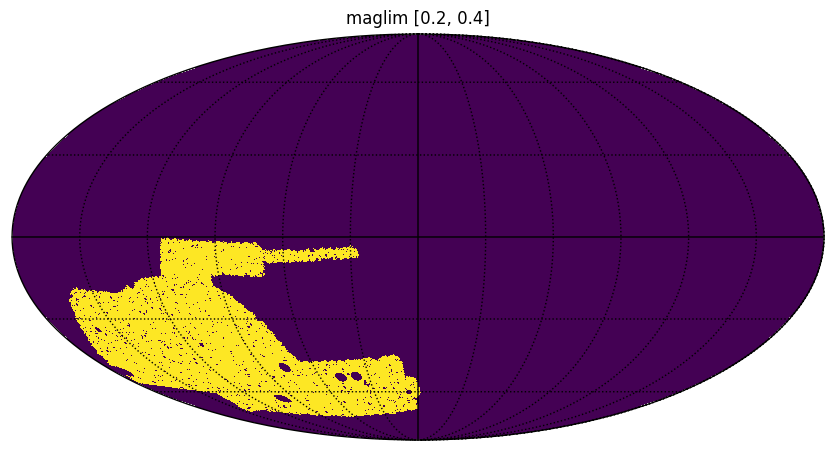

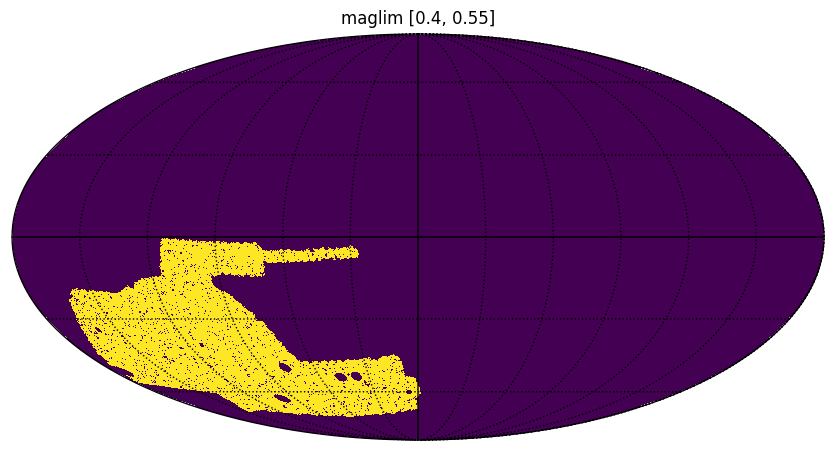

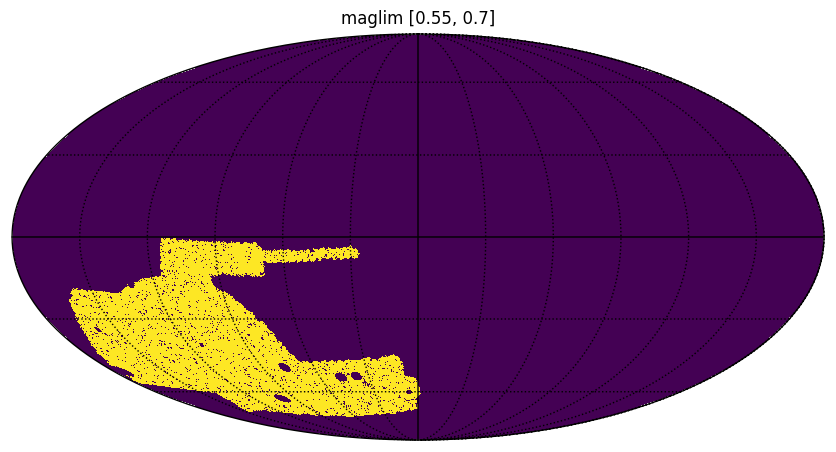

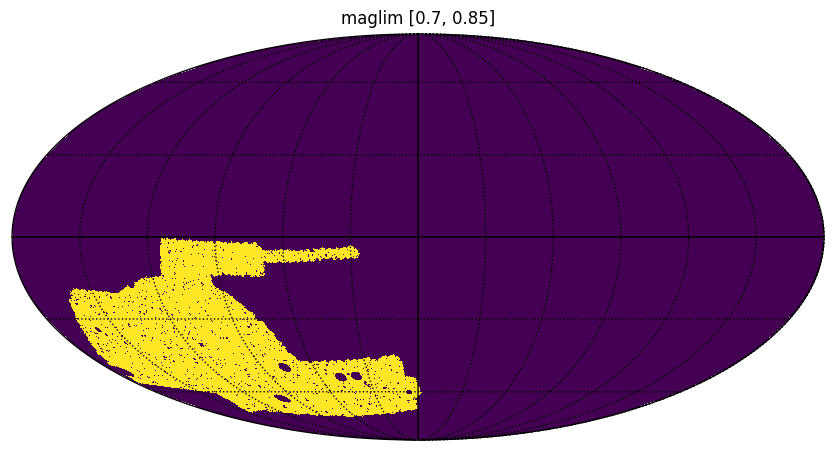

In [9]:
y_rot = get_rot_y(-0.125)
z_rot = get_rot_z(-1.22)

per_bin_pix = []
# for sample in ["metacal", "maglim"]:
for sample in ["maglim"]:
    if sample == "metacal":
        indices = indices_metacal
    elif sample == "maglim":
        indices = indices_maglim
        # mask = 
    else:
        raise ValueError("Unknown sample")
    
    z_lims = conf["survey"][sample]["z_lims"]
    z = gold_z[indices]
    
    for z_lim in z_lims:
        z_mask = (z_lim[0] < z) & (z < z_lim[1])
        z_indices = indices[z_mask]

        # print(f"{sample} {z_lim} {len(z_indices):.2E}")
        print(f"{sample} {z_lim} {len(z_indices)}")

        ra = gold_ra[z_indices]
        dec = gold_dec[z_indices]

        theta = np.pi/2 - np.radians(dec)
        phi = np.radians(ra)
        vec = hp.ang2vec(theta=theta, phi=phi)
        
        rot_vec = np.dot(y_rot, vec.T)
        rot_vec = np.dot(z_rot, rot_vec)
        rot_pix = hp.vec2pix(n_side, rot_vec[0], rot_vec[1], rot_vec[2])

        mask = np.zeros(n_pix, dtype=bool)
        mask[rot_pix] = True
        hp.mollview(mask, cbar=False, title=sample + " " + str(z_lim))
        hp.graticule()

        per_bin_pix.append(rot_pix)


In [10]:
# # Convert each list to a set
# pix_sets = [set(pixels) for pixels in per_bin_pix]

# # Find the intersection of all sets
# pix_intersect = set.intersection(*pix_sets)
# pix_intersect = np.array(list(pix_intersect))

# mask = np.zeros(n_pix, dtype=bool)
# mask[pix_intersect] = True
# hp.mollview(mask, cbar=False, title=sample)
# hp.graticule()